# Use code from https://www.kaggle.com/endoruk1234/trafficlightdetection-fasterrcnn-pytorch#Reading-CSV-File-and-Preprocessing

In [1]:
import torch
from PreData import GetDataset
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

In [7]:
class arguments():
    pixel = 100 # image pixels
    epochs = 1
    batch_size = 64
    seed = 0
    device = 'cpu'
    image_time = 'day' # or night
    parent_path = '../app-data/RawData/'
    annotation_path = '../app-data/RawData/Annotations/'+image_time+'Train'   # './RawData/Annotations/nightTrain/'
args = arguments

In [8]:
trainDataset, valDataset, testDataset = GetDataset(args)
print(len(trainDataset), len(valDataset), len(testDataset))

100%|██████████| 13/13 [00:00<00:00, 94.54it/s]


8596 2275 1904


In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

trainDataLoader = DataLoader(
    trainDataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
    )

valDataLoader = DataLoader(
        valDataset,
        batch_size=64,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )

testDataLoader = DataLoader(
        testDataset,
        batch_size=64,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )

In [10]:
images, labels = next(iter(trainDataLoader))
images = torch.stack(images)
labels = torch.stack(labels)
print(images.shape, labels.shape)

torch.Size([64, 3, 100, 100]) torch.Size([64])


tensor(0.)


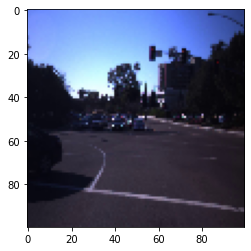

In [11]:
i = 7
print(labels[i])
img = np.array(np.transpose(images, (0,2,3,1)))
f, ax = plt.subplots()
ax.imshow(img[i,:,:,:])

<font color = 'red'>
Content: 

1. [Importing Libraries](#1)
1. [Reading CSV File and Preprocessing](#2)
1. [Hyperparameters](#3)
1. [Selecting Device (GPU - CPU)](#4)
1. [Defining Dataset and Dataloader](#5)
1. [Display Frames](#6)
1. [Training FasterRCNN Model](#7)
1. [Saving Models](#8)
1. [Loading Model](#9)
1. [Testing on Video with OpenCV](#10)


<a id = "1"></a><br>
# Importing Libraries

In [148]:
from time import time
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

# torch.cuda.empty_cache() 

import os

<a id = "2"></a><br>
# Reading CSV File and Preprocessing

In [149]:
DATA_PATH = './RawData'
DAY_TRAIN_PATH = './RawData/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = './RawData/Annotations/nightTrain/'
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)

100%|██████████| 13/13 [00:00<00:00, 53.51it/s]


In [150]:
df = train_day_df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [151]:
def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
   
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [152]:
print(df)

                                               Filename Annotation tag  \
0     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...             go   
1     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...             go   
2     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...             go   
3     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...             go   
4     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...             go   
...                                                 ...            ...   
1935  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...         goLeft   
1936  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...         goLeft   
1937  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...    warningLeft   
1938  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...    warningLeft   
1939  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...    warningLeft   

      Upper left corner X  Upper left corner Y  Lower right corner X  \
0                     698              

In [153]:
df['Annotation tag'].unique()

array(['go', 'stop', 'stopLeft', 'warning', 'goLeft', 'warningLeft'],
      dtype=object)

In [154]:
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([1, 3, 2])

In [155]:
print(df['Annotation tag'])

0       1
1       1
2       1
3       1
4       1
       ..
1935    1
1936    1
1937    2
1938    2
1939    2
Name: Annotation tag, Length: 37810, dtype: int64


In [156]:
print(df)

                                               Filename  Annotation tag  \
0     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...               1   
1     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...               1   
2     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...               1   
3     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...               1   
4     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...               1   
...                                                 ...             ...   
1935  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...               1   
1936  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...               1   
1937  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...               2   
1938  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...               2   
1939  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...               2   

      Upper left corner X  Upper left corner Y  Lower right corner X  \
0                     698  

In [157]:
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame']

In [158]:
print(df)

                                               image_id  label  x_min  y_min  \
0     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...      1    698    333   
1     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...      1    846    391   
2     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...      1    698    337   
3     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...      1    847    390   
4     ./RawData/dayTrain/dayTrain/dayClip1/frames/da...      1    698    331   
...                                                 ...    ...    ...    ...   
1935  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...      1    971    174   
1936  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...      1   1021    171   
1937  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...      2   1115    182   
1938  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...      2   1155    186   
1939  ./RawData/dayTrain/dayTrain/dayClip9/frames/da...      2   1217    182   

      x_max  y_max  frame  
0       710

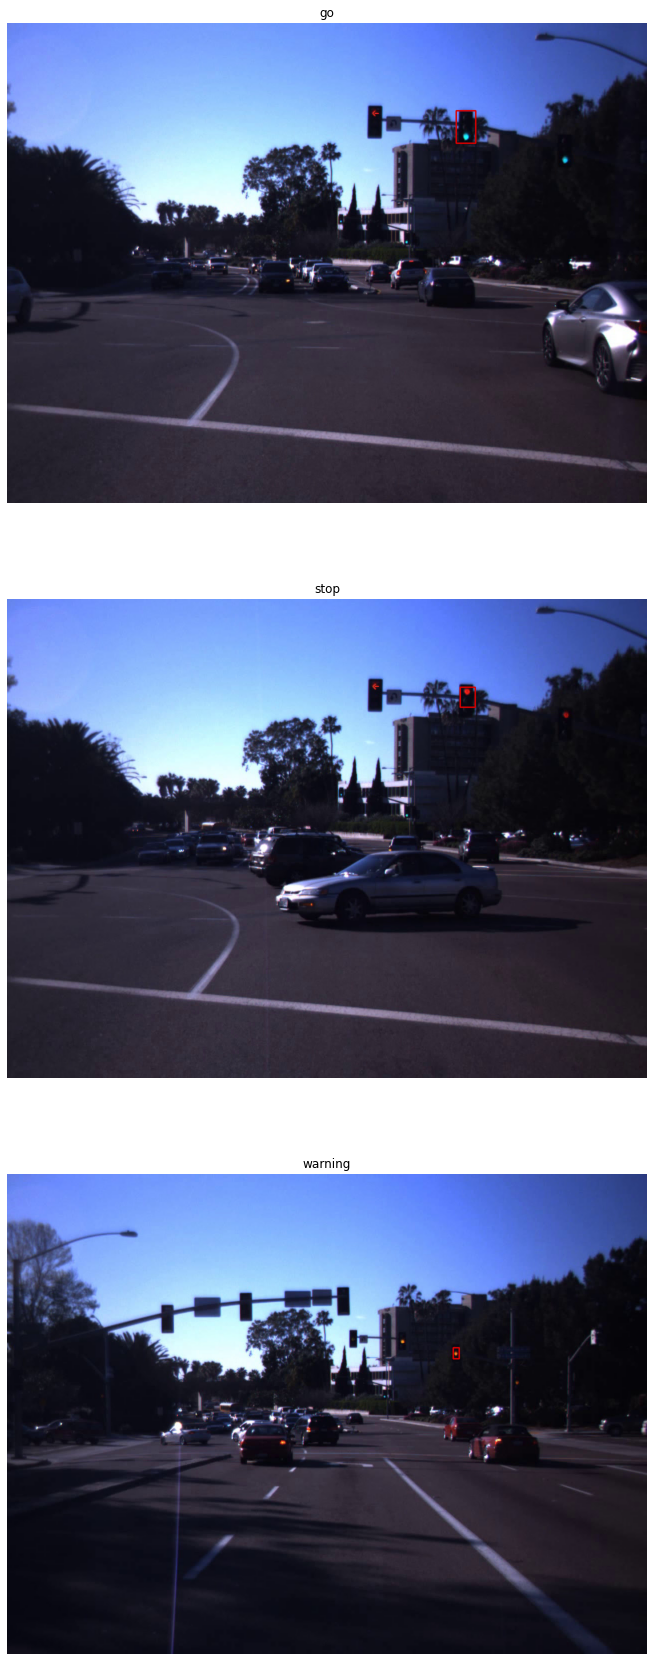

In [159]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [160]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[4])
df['clipNames'].unique()

array(['dayClip1', 'dayClip10', 'dayClip11', 'dayClip12', 'dayClip13',
       'dayClip2', 'dayClip3', 'dayClip4', 'dayClip5', 'dayClip6',
       'dayClip7', 'dayClip8', 'dayClip9'], dtype=object)

In [161]:
def split(df,p=0.2):
    clipNames = sorted(df['clipNames'].unique())

    dayClips = [name for name in clipNames if 'day' in name]

    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames =  testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainClipNames =  trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df


In [162]:
train_df, test_df = split(df)
train_df, val_df = split(train_df)

In [163]:
print(len(train_df))
print(train_df.label.values)

25803
[1 1 1 ... 2 2 2]


<a id = "3"></a><br>
# Hyperparameters

In [164]:
EPOCHS = 1
BATCH_SIZE = 64

<a id = "4"></a><br>
# Selecting Device (GPU - CPU)

In [165]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = 'cpu'
print(device)

cpu


<a id = "5"></a><br>
# Defining Dataset and Dataloader

In [212]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        motion_labels = torch.as_tensor(self.df.label.values[index],dtype=torch.float32)
        
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])
            
        return image, motion_labels, target, image_id

In [213]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [214]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [215]:
def getTrainTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        # A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getValTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getTestTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [216]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
valDataset = TrafficLightsDataset(val_df,getValTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())

In [217]:
print(len(trainDataset))

8429


In [218]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

<a id = "6"></a><br>
# Display Frames 

In [219]:
images, labels,  targets, image_ids = next(iter(trainDataLoader))

boxes = targets[3]['boxes'].numpy().astype(np.int32)
image = images[3].permute(1,2,0).numpy()

In [232]:
print(torch.stack(images).shape)
print(torch.stack(labels))

torch.Size([64, 3, 256, 256])
tensor([1., 1., 1., 3., 1., 1., 1., 1., 3., 1., 3., 1., 1., 3., 3., 3., 3., 1.,
        3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        3., 3., 3., 1., 3., 1., 1., 3., 3., 1., 1., 3., 1., 1., 3., 3., 1., 1.,
        3., 3., 3., 1., 3., 3., 3., 3., 3., 1.])


In [221]:
print(len(images), images[0].shape)
print(len(targets), targets[3]['labels'])

64 torch.Size([3, 256, 256])
64 tensor([3, 3, 3])


In [222]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 1)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


./RawData/dayTrain/dayTrain/dayClip5/frames/dayClip5--01358.jpg


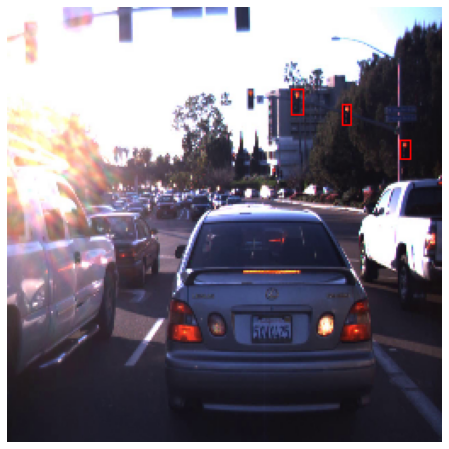

In [223]:
print(image_ids[0])
displayImage(image,boxes)

<a id = "7"></a><br>
# Training FasterRCNN Model

In [224]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

N_CLASS = 4 

INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

In [225]:
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [226]:
# lossHist = LossAverager()
# valLossHist = LossAverager()

# for epoch in range(EPOCHS):
    
#     start_time = time()
#     model.train()
#     lossHist.reset()
    
#     for images, targets, image_ids in tqdm(trainDataLoader):
        
#         images = torch.stack(images).to(device)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#         bs = images.shape[0]
        
#         loss_dict = model(images, targets)
        
#         totalLoss = sum(loss for loss in loss_dict.values())
#         lossValue = totalLoss.item()
        
#         lossHist.update(lossValue,bs)

#         optimizer.zero_grad()
#         totalLoss.backward()
#         optimizer.step()
    
#     if lr_scheduler is not None:
#         lr_scheduler.step(totalLoss)

#     print(f"[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}]")
#     print(f"Epoch {epoch}/{EPOCHS}")
#     print(f"Train loss: {lossHist.avg}")
    
#     if(epoch == 10):
#         torch.save(model.state_dict(), 'fasterrcnn_resnet{}_fpn.pth'.format(epoch))

<a id = "8"></a><br>
# Saving Models

In [227]:
# torch.save(model.state_dict(), 'fasterrcnn_resnet{}_fpn.pth'.format(epoch))

<a id = "9"></a><br>
# Loading Models

In [228]:
# model.load_state_dict(torch.load('../input/weights/fasterrcnn_resnet50_fpn.pth'))

<a id = "10"></a><br>
# Testing on Video with OpenCV

In [229]:
# preprocess = transforms.Compose([
#     transforms.ToTensor()
# ])

# cap = cv2.VideoCapture("project.avi")

# while(True):
#     ret, input = cap.read()
#     image = input.copy()
#     input = preprocess(input).float()
#     input = input.unsqueeze_(0)
#     input = input.type(torch.cuda.FloatTensor)

#     result = model(input)

#     boxes = result[0]['boxes'].type(torch.cuda.FloatTensor)
#     scores = result[0]['scores'].type(torch.cuda.FloatTensor)
#     labels = result[0]['labels'].type(torch.cuda.FloatTensor)

#     mask = nms(boxes,scores,0.3)
#     boxes = boxes[mask]
#     scores = scores[mask]
#     labels = labels[mask]

#     boxes = boxes.data.cpu().numpy().astype(np.int32)
#     scores = scores.data.cpu().numpy()
#     labels = labels.data.cpu().numpy()

#     mask = scores >= 0.5
#     boxes = boxes[mask]
#     scores = scores[mask]
#     labels = labels[mask]

#     colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}

#     for box,label in zip(boxes,labels):
#         image = cv2.rectangle(image,
#                           (box[0], box[1]),
#                           (box[2], box[3]),
#                           (0,0,255), 1)

#     cv2.imshow("image", image)
    
#     if cv2.waitKey(0):
#         break
    